In [7]:
from pathlib import Path
import os, sys, pandas as pd, numpy as np, cv2, matplotlib.pyplot as plt
from shapely import wkt

# ---------- 1) Find the dataset base (robust on Windows) ----------
def find_data_base():
    # Highest priority: explicit env var (set once if your layout differs)
    env = os.getenv("XBD_DATA_DIR")
    if env:
        p = Path(env).expanduser().resolve()
        if p.exists():
            print(f"[use] XBD_DATA_DIR -> {p}")
            return p

    # Common locations relative to current notebook / script
    candidates = [
        Path.cwd() / "data" / "xBD",
        Path.cwd() / "data" / "xBD Dataset",
        Path.cwd().parents[0] / "data" / "xBD",
        Path.cwd().parents[0] / "data" / "xBD Dataset",
    ]
    for c in candidates:
        if c.exists():
            print(f"[use] found dataset at -> {c}")
            return c

    raise FileNotFoundError(
        "Couldn't find the dataset folder.\n"
        "Tried:\n  - ./data/xBD\n  - ./data/xBD Dataset\n"
        "Fixes:\n  1) Run the downloader so data is at ./data/xBD\n"
        "  2) Or set env var XBD_DATA_DIR to the absolute path of your xBD folder.\n"
        "     Example (PowerShell):  $env:XBD_DATA_DIR='C:\\Users\\YOU\\Desktop\\RECAP\\data\\xBD'\n"
        "     Example (bash/zsh)  :  export XBD_DATA_DIR='/home/you/RECAP/data/xBD'"
    )

DATA_BASE = find_data_base()
# ---------- 2) Locate index.csv ----------
csv_candidates = [
    Path.cwd() / "info" / "index.csv",
    Path.cwd().parents[0] / "info" / "index.csv",
    Path.cwd() / "index.csv",
]
for p in csv_candidates:
    if p.exists():
        CSV_PATH = p
        break
else:
    raise FileNotFoundError(
        f"index.csv not found.\nChecked:\n" + "\n".join(f" - {p}" for p in csv_candidates)
        + "\nPut index.csv in ./info/index.csv next to your notebook/script."
    )

print(f"[use] index.csv -> {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("[ok] rows:", len(df))


[use] found dataset at -> /Users/aryananand/Documents/RECAP/data/xBD Dataset
[use] index.csv -> /Users/aryananand/Documents/RECAP/info/index.csv
[ok] rows: 159794


[chk] pre  -> /Users/aryananand/Documents/RECAP/data/xBD Dataset/train/images/hurricane-harvey_00000358_pre_disaster.png  | exists: True
[chk] post -> /Users/aryananand/Documents/RECAP/data/xBD Dataset/train/images/hurricane-harvey_00000358_post_disaster.png | exists: True


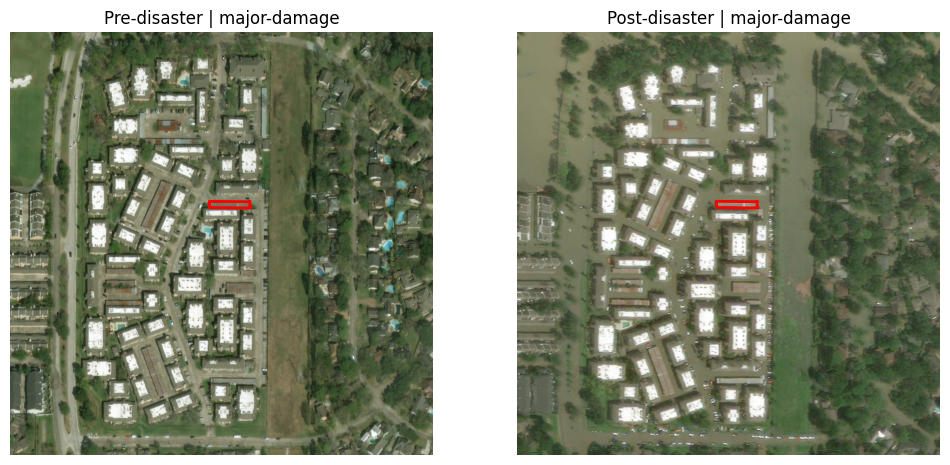

In [8]:
# ---------- 3) Build correct image paths from CSV row ----------
def row_to_paths(row):
    # Strip the filename from CSV paths (which may have wrong backslashes/name)
    pre_name  = Path(str(row["pre_path"]).replace("\\", "/")).name
    post_name = Path(str(row["post_path"]).replace("\\", "/")).name

    split = str(row["split"]).strip().lower()  # 'train' or 'test'
    pre_p  = (DATA_BASE / split / "images" / pre_name).resolve()
    post_p = (DATA_BASE / split / "images" / post_name).resolve()
    return pre_p, post_p
# ---------- 3) Build correct image paths from CSV row ----------
def row_to_paths(row):
    # Strip the filename from CSV paths (which may have wrong backslashes/name)
    pre_name  = Path(str(row["pre_path"]).replace("\\", "/")).name
    post_name = Path(str(row["post_path"]).replace("\\", "/")).name

    split = str(row["split"]).strip().lower()  # 'train' or 'test'
    pre_p  = (DATA_BASE / split / "images" / pre_name).resolve()
    post_p = (DATA_BASE / split / "images" / post_name).resolve()
    return pre_p, post_p

# ---------- 4) Pick a row & validate before reading ----------
row = df.sample(1).iloc[0]  # or pick a specific row by condition
pre_p, post_p = row_to_paths(row)

print(f"[chk] pre  -> {pre_p}  | exists: {pre_p.exists()}")
print(f"[chk] post -> {post_p} | exists: {post_p.exists()}")

if not pre_p.exists() or not post_p.exists():
    # Helpful hints if names don't match
    some_files = list((DATA_BASE / str(row["split"]).lower() / "images").glob("*.png"))[:5]
    example_list = "\n".join(f"   - {f.name}" for f in some_files)
    raise FileNotFoundError(
        "One or both image files are missing at the rebuilt paths.\n"
        f"Expected:\n  {pre_p}\n  {post_p}\n\n"
        f"Sample files actually present in that folder:\n{example_list or '   (no .png files found)'}\n\n"
        "If your dataset folder name is different, set XBD_DATA_DIR to its absolute path and re-run."
    )

# ---------- 5) Safe image read (no NoneType) ----------
pre_img  = cv2.imread(str(pre_p), cv2.IMREAD_COLOR)
post_img = cv2.imread(str(post_p), cv2.IMREAD_COLOR)
if pre_img is None:  raise RuntimeError(f"OpenCV failed to read: {pre_p}")
if post_img is None: raise RuntimeError(f"OpenCV failed to read: {post_p}")

pre_img  = cv2.cvtColor(pre_img,  cv2.COLOR_BGR2RGB)
post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

# ---------- 6) Polygon overlay ----------
poly = wkt.loads(row["polygon_wkt"])
xs, ys = zip(*list(poly.exterior.coords))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, img, title in zip(axes, [pre_img, post_img], ["Pre-disaster", "Post-disaster"]):
    ax.imshow(img)
    ax.plot(xs, ys, color="red", linewidth=2)
    ax.set_title(f"{title} | {row['label_name']}")
    ax.axis("off")
plt.show()

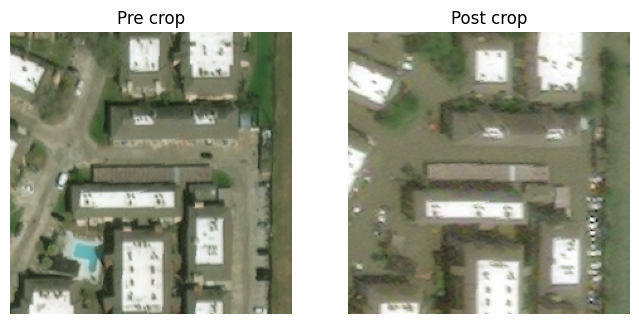

In [9]:
# ---------- 7) Optional: crop 224x224 around centroid ----------
chip = 224
cx, cy = map(int, wkt.loads(row["polygon_wkt"]).centroid.coords[0])

def crop_center(img, cx, cy, size=224):
    h, w = img.shape[:2]
    half = size // 2
    x1, x2 = max(0, cx-half), min(w, cx+half)
    y1, y2 = max(0, cy-half), min(h, cy+half)
    chip = img[y1:y2, x1:x2]
    pad  = np.zeros((size, size, 3), dtype=np.uint8)
    pad[:chip.shape[0], :chip.shape[1]] = chip
    return pad

pre_chip  = crop_center(pre_img,  cx, cy, chip)
post_chip = crop_center(post_img, cx, cy, chip)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(pre_chip);  axes[0].set_title("Pre crop");  axes[0].axis("off")
axes[1].imshow(post_chip); axes[1].set_title("Post crop"); axes[1].axis("off")
plt.show()